In [320]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import scipy.linalg as la
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score

In [353]:
def spectral_clustering(X, k, M):
    
    if (M >= X.shape[1]) | (not isinstance(M, int)) | (k < 2) | (k > X.shape[1]) | (not isinstance(k, int)) | (M < 1):
        return("Niepoprawne dane")
    # liczba M musi być naturalna, większa od zera, oraz mniejsza od liczby wszystkich wektorów
    # liczba k musi byc naturalna, większa od 1, mniejsza bądź równa liczbie wszystkich wektorów, 
    # bo nie można pokolorować grafu na więcej kolorów, niż ma wierzchołków
    
    else:
        
        def Mnn(X, M):
            disteuc = cdist(np.transpose(X), np.transpose(X))
            S = []
            for j in range(X.shape[1]):
                dict_euc = {}
                for i in range(X.shape[1]):
                    dict_euc[disteuc[:,j][i]] = i
                S.append([dict_euc[i] for i in np.sort(disteuc[:,j])[1:(M+1)]])
            return np.transpose(np.array(S))   
        # disteuc - macierz z odleglosciami id kolejnych wektorów policzony w metryce euklidesowej
        # dict_euc - słownik który każdej wartości odległości ma przypisany numer wektora, do którego jest ta odległość
        # np.sort(disteuc[:,j])[1:(M+1)] - sortujemy i wybieramy M najbbliższych sąsiadów 
        # za pomocą stworzonego słownika tworzymy listę zawierającą indeksy najbliższych sąsiadów
        # powtarzamy to dla wszystkich kolumn w disteuc i otrzymane wyniki zapisujemy w S
        # otrzymaną listę zapisujemy jako arrey i transponujemy -  to jest końcowy wynik funkcji Mnn
        
        def Mnn_graph(S):
            G = np.zeros((S.shape[1], S.shape[1]))
            for i in range(S.shape[1]):
                G[i,S[:,i]] = 1
                G[S[:,i],i] = 1

            nr_of_comp, array_of_comp = connected_components(G)   
            if (nr_of_comp != 1):
                dict_com = {}
                for i in range(G.shape[1]):
                    dict_com[array_of_comp[i]] =  i  
                for i in range(nr_of_comp-1):
                    G[dict_com[i],dict_com[i+1]] = 1
                    G[dict_com[i+1],dict_com[i]] = 1     
            return G  
        # Tworzymy macierz zer G i tam gdzie punkty są bliskie według macierzy S dostawiamy 1. 
        # Za pomocą funkcji connected_components(G) zdobywamy liczbę składowych spójności nr_of_comp 
        # oraz informacji o przynalieżności każdego punktu do danej składowej array_of_comp 
        # jeśli liczba składowych jest różna od 1, to musimy uspójnić graf. 
        # Tworzymy w tym celu słownik dict_com, w którym zawierają się informacje o składowej spójności 
        # i jakimś elemencie należącym do niego. 
        # I teraz łączymy te kolejne elementy z każdej składowej, czyli łaczymy każdą składową, czyli uspójniliśmy graf. 
        
        def Laplacian_eigen(G, k):
            D = np.zeros(G.shape)
            for i in range(G.shape[1]):
                D[i,i] = sum(G[:,i])
            L = D - G
            evals, evecs = la.eig(L)
            dict_eval = {}
            for i in range(L.shape[1]):
                dict_eval[evals[i]] = i
            chosen_values = [dict_eval[i] for i in np.sort(evals)[1:(k+1)]]
            return evecs[:,chosen_values]
        # Tworymy macierz D, ktora na diagonali ma stopnie danych wierzcholkow, czyli liczbe wsystkich krawedzi wychodzacych 
        # z tego wierzcholka. Dalej tworzymy macierz L. Wyznaczamy wartości i wektry własne - evals, evecs.
        # Tworzymy pomocniczy słownik, który wykorzystujemy podobnie jak w funkcji Mnn. Z tak wyznavzonych wartości własnych 
        # wybieramy wektory właśne i otrzymujemy to co chcieliśmy. 
        
        S = Mnn(X, M)
        G = Mnn_graph(S)
        E = Laplacian_eigen(G, k)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(E)
        # Uruchamiamy nasze funkcjie pomocniczne i na koniec posługujemy sie funkcją KMeans.
        # Z tak otrzymanego wyniku wybieramy wektor podziału i to zwracamy w końcowej funkcji. 
        
        return kmeans.labels_

In [374]:
# parametry M i k
k = 2
M = 4 

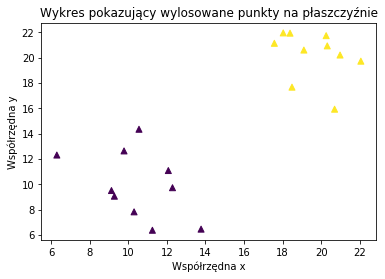

In [375]:
#Przykład 1
np.random.seed(17)
n1 = 10
d1 = 2
mu = 10.0
sigma = 2.0
X1 = np.random.randn(d1,n1) * sigma + mu
mu = 20.0
sigma = 2.0
X2 = np.random.randn(d1,n1) * sigma + mu

X = np.concatenate([X1,X2],axis = 1)

x = X[0]
y = X[1]
c = spectral_clustering(X, k, M)

plt.xlabel('Współrzędna x')
plt.ylabel('Współrzędna y')
plt.title('Wykres pokazujący wylosowane punkty na płaszczyźnie')
plt.scatter(x, y, marker='^', c=c)

In [376]:
c1 = spectral_clustering(X, k, 4)
c2 = spectral_clustering(X, k, 6)
fowlkes_mallows_score(c1, c2)

1.0

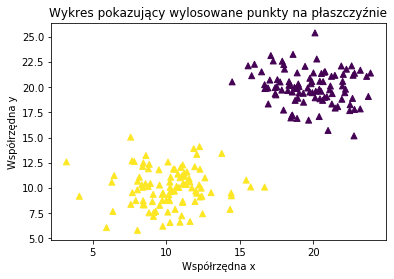

In [377]:
#Przykład 2
np.random.seed(17)
n1 = 100
d1 = 2
mu = 10.0
sigma = 2.0
X1 = np.random.randn(d1,n1) * sigma + mu
mu = 20.0
sigma = 2.0
X2 = np.random.randn(d1,n1) * sigma + mu

X = np.concatenate([X1,X2],axis = 1)

x = X[0]
y = X[1]
c = spectral_clustering(X, k, M)

plt.xlabel('Współrzędna x')
plt.ylabel('Współrzędna y')
plt.title('Wykres pokazujący wylosowane punkty na płaszczyźnie')
plt.scatter(x, y, marker='^', c=c)

In [382]:
c1 = spectral_clustering(X, k, 4)
c2 = spectral_clustering(X, k, 20)
fowlkes_mallows_score(c1, c2)

1.0

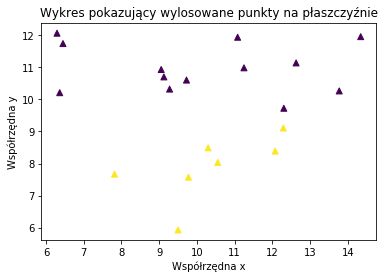

In [383]:
#Przykład 3
np.random.seed(17)
n1 = 20
d1 = 2
mu = 10.0
sigma = 2.0
X = np.random.randn(d1,n1) * sigma + mu

x = X[0]
y = X[1]
c = spectral_clustering(X, k, M)

plt.xlabel('Współrzędna x')
plt.ylabel('Współrzędna y')
plt.title('Wykres pokazujący wylosowane punkty na płaszczyźnie')
plt.scatter(x, y, marker='^', c=c)

In [384]:
c1 = spectral_clustering(X, k, 4)
c2 = spectral_clustering(X, k, 6)
fowlkes_mallows_score(c1, c2)

0.6637465183030646

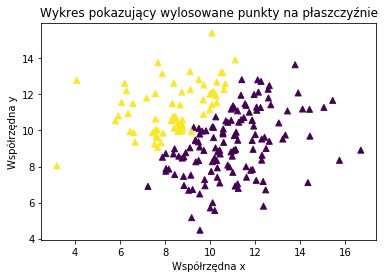

In [385]:
#Przykład 4
np.random.seed(17)
n1 = 200
d1 = 2
mu = 10.0
sigma = 2.0
X = np.random.randn(d1,n1) * sigma + mu

x = X[0]
y = X[1]
c = spectral_clustering(X, k, M)

plt.xlabel('Współrzędna x')
plt.ylabel('Współrzędna y')
plt.title('Wykres pokazujący wylosowane punkty na płaszczyźnie')
plt.scatter(x, y, marker='^', c=c)

In [386]:
# porównanie k-podziałów 
c1 = spectral_clustering(X, k, 4)
c2 = spectral_clustering(X, k, 20)
fowlkes_mallows_score(c1, c2)

0.5295708743545161

In [387]:
# porównanie k-podziałów 
c1 = spectral_clustering(X, k, 4)
c2 = spectral_clustering(X, k, 6)
fowlkes_mallows_score(c1, c2)

0.9553688417596256